### Objective

In this notebook I resume work done at the [2018 Geophysics Sprint](https://mycarta.wordpress.com/2019/02/07/geophysics-python-sprint-2018-day-2-and-beyond-part-ii) (orgainzed by Agile Scientific ahead of the Annual SEG conference).  

I was inspired to go back to it after watching a Stanford University webinar titled [How to be a statistical detective](https://learn.stanford.edu/WBN-MED-STATS-On-Demand-2020-02-05_LP-OD-Registration-2020-02-11.html). 

### License

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"> CC BY Creative Commons License</a>.

### Preliminaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib  import gridspec
import numpy as np
import scipy as sp
from scipy import interpolate
from itertools import groupby
import seaborn as sns
from skimage import io

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

###  Load example data: acustic impedance from inversion paper

I will now use the error flag function to evaluate the quality of seismic inversion form a published article in the November 2009 CSEG Recorder [Inversion Driven Processing](https://csegrecorder.com/assets/pdfs/2009/2009-11-RECORDER-Inversion_Driven_Processing.pdf).  In the article, the evaluation was done by the authors at a blind well location, but only qualitatively, as illustrated in Figure 5, shown below for reference.  In the top panel (a) the evaluation is for the inversion without SPNA (Signal Protected Noise Attenuation); in the bottom panel (b) for the inversion with SPNA.  On the right side of each panel the inverted seismic trace is plotted against the upscaled impedance well log (calculated by multiplying the well density log and the well velocity log from compressional sonic); on the right, the upscaled impedance log is inserted in a seismic impedance section as a colored trace (at the location of the well) using the same color scale and range used for the impedance section.

<function matplotlib.pyplot.show(*args, **kw)>

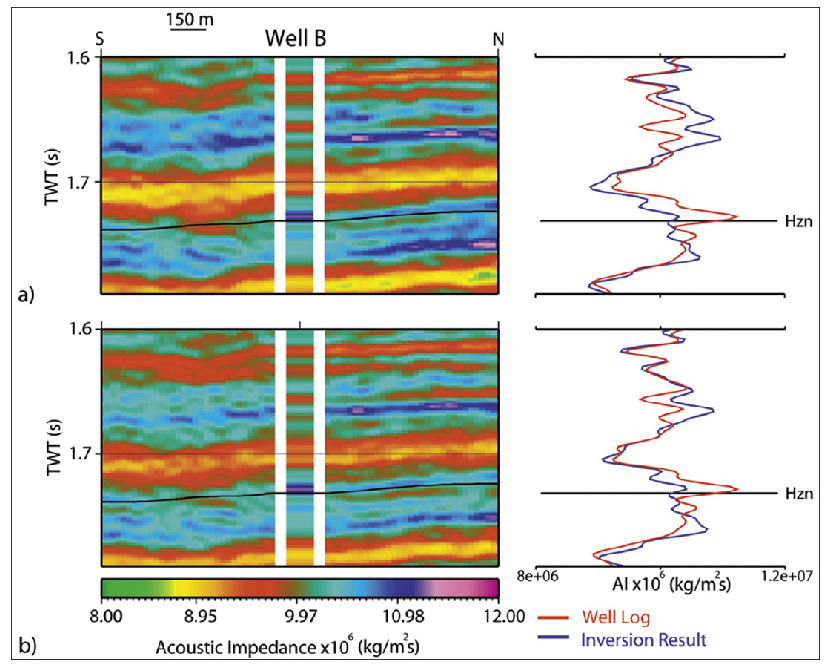

In [3]:
url = 'https://csegrecorder.com/assets/images/articles/2009-11-inversion-driven-fig05.jpg'
fig05=io.imread(url)

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(fig05)
plt.show

__Figure 5 caption__: _Acoustic impedance results at the blind well for data without (a) and with (b) SPNA. The figure shows a 200ms window of inverted seismic data with well B, the blind well, in the middle on the left, along with acoustic impedance curves for the well (red) and inverted seismic (blue) on the right. The data with SPNA shows a better fit to the well, particularly over the low frequencies_.

That is the extent of the evaluation: _"The data with SPNA shows a better fit to the well, particularly over the low frequencies"_.  Unfortunately this is not accompanied by any quantitative measure, like an R^2 for for the two methods. In the remainder of the notebook I will try to do a quantitative comparison, using the error flag function, and other metrics.

### Take the data out of the figure....

The logs and inversion traces were hand-digitized (by me) from the figure above, so they will require interpolation to regularly-sampled time intervals; also (I'm being my own devil's advocate) small differences in the digitizing of curves in panel (a) vs panel (b) are inevitable, and will affect the error calculations, but I deem this a lesser evil.

__N.B.  To digitize plots/graphs (and run some tests on the data, or re-plot) - use WebPlotDigitizer: https://apps.automeris.io/wpd/__

#### Add logs and traces

In [4]:
log_a = np.loadtxt('data/Recorder09_upscaled_log_a.csv', delimiter=',')[:,1]
log_a_t = np.loadtxt('data/Recorder09_upscaled_log_a.csv', delimiter=',')[:,0]

In [5]:
log_b = np.loadtxt('data/Recorder09_upscaled_log_b.csv', delimiter=',')[:,1]
log_b_t = np.loadtxt('data/Recorder09_upscaled_log_b.csv', delimiter=',')[:,0]

In [6]:
inv_a = np.loadtxt('data/Recorder09_inversion_a.csv', delimiter=',')[:,1]
inv_a_t = np.loadtxt('data/Recorder09_inversion_a.csv', delimiter=',')[:,0]

In [7]:
inv_b = np.loadtxt('data/Recorder09_inversion_b.csv', delimiter=',')[:,1]
inv_b_t = np.loadtxt('data/Recorder09_inversion_b.csv', delimiter=',')[:,0]

In [8]:
fina = interpolate.interp1d(inv_a_t, inv_a)
finb = interpolate.interp1d(inv_b_t, inv_b)
floa = interpolate.interp1d(log_a_t, log_a)
flob = interpolate.interp1d(log_b_t, log_b)

time = np.arange(1.604, 1.8, 0.002)

ina = fina(time)
inb = finb(time)
loa = floa(time)
lob = flob(time)

In [9]:
result_a = pd.DataFrame({'time': time, 'inv': ina, 'log': loa})
result_b = pd.DataFrame({'time': time, 'inv': inb, 'log': lob})

In [10]:
result_a.head()

,time,inv,log
0,1.604,10.084,10.180000
1,1.606,10.287,10.220500
2,1.608,10.448,10.261000
3,1.610,10.502,10.257000
4,1.612,10.314,10.113667


#### Add the horizon

In [11]:
hrzn = np.genfromtxt('data/Recorder09_tops.csv', delimiter=',')[0, 1]

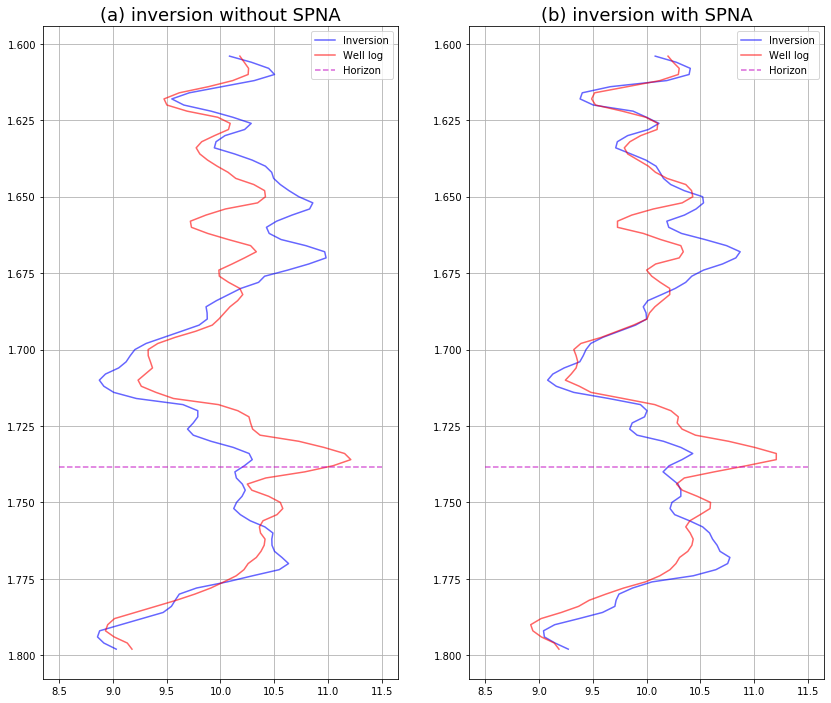

In [12]:
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(121)
ax1.plot(result_a.inv,result_a.time,'b', alpha = 0.6, label = 'Inversion')
ax1.plot(result_a.log,result_a.time,'r', alpha = 0.6, label = 'Well log')
ax1.plot([8.5, 11.5], [hrzn, hrzn], 'm--', alpha = 0.6, label = 'Horizon')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()
ax1.set_title('(a) inversion without SPNA', fontsize = 18)

ax2 = fig.add_subplot(122)
ax2.plot(result_b.inv,result_b.time,'b', alpha = 0.6, label = 'Inversion')
ax2.plot(result_b.log,result_b.time,'r', alpha = 0.6, label = 'Well log')
ax2.plot([8.5, 11.5], [hrzn, hrzn], 'm--', alpha = 0.6, label = 'Horizon')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()
ax2.set_title('(b) inversion with SPNA', fontsize = 18);

#### Add a fake top

I will do my evaluation in an upper and lower zone. Rather than using the seismically-picked horizon, I decided to add a fake top at 1.715 seconds, where I see a sharp increase in impedance. This is an arbitrary choise on my part of a more geological horizon (separating the yellow-red band from the green blue band in the impedance sections).

In [13]:
fake_top = 1.715

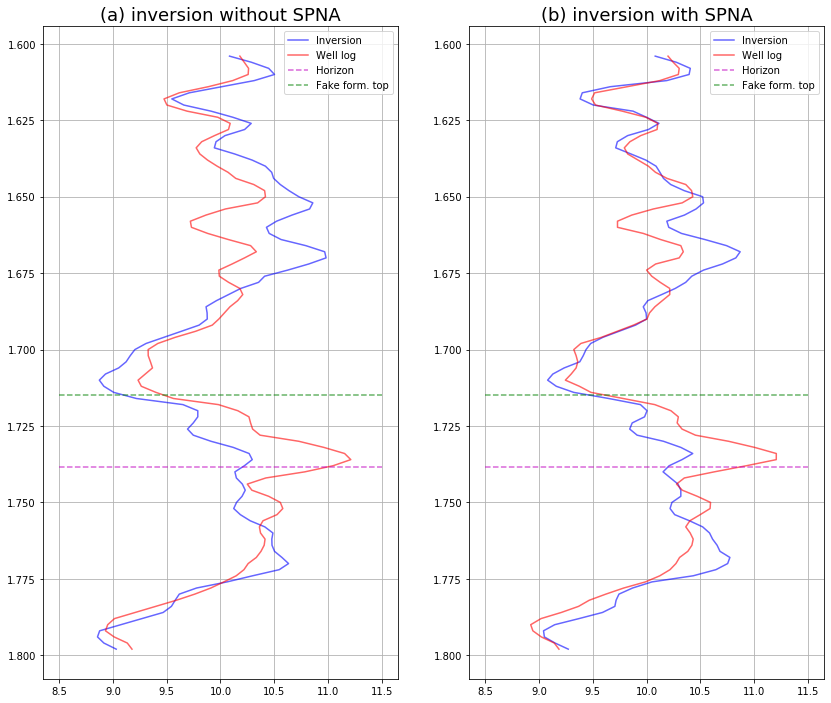

In [14]:
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(121)
ax1.plot(result_a.inv,result_a.time,'b', alpha = 0.6, label = 'Inversion')
ax1.plot(result_a.log,result_a.time,'r', alpha = 0.6, label = 'Well log')
ax1.plot([8.5, 11.5], [hrzn, hrzn], 'm--', alpha = 0.6, label = 'Horizon')
ax1.plot([8.5, 11.5], [1.715, 1.715], 'g--', alpha = 0.6, label = 'Fake form. top')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()
ax1.set_title('(a) inversion without SPNA', fontsize = 18)

ax2 = fig.add_subplot(122)
ax2.plot(result_b.inv,result_b.time,'b', alpha = 0.6, label = 'Inversion')
ax2.plot(result_b.log,result_b.time,'r', alpha = 0.6, label = 'Well log')
ax2.plot([8.5, 11.5], [hrzn, hrzn], 'm--', alpha = 0.6, label = 'Horizon')
ax2.plot([8.5, 11.5], [fake_top, fake_top], 'g--', alpha = 0.6, label = 'Fake form. top')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()
ax2.set_title('(b) inversion with SPNA', fontsize = 18);


### Comparing results of inversion with and without SPNA

#### Method 1: calculate the RMS error by zone

I use the fake top to make an upper zone and a lower zone:

In [15]:
result_a['zone']= 'Upper'
result_a.loc[result_a.time >fake_top, 'zone'] = 'Lower'
result_b['zone']= 'Upper'
result_b.loc[result_b.time >fake_top, 'zone'] = 'Lower'

Let's check some of the top and bottom rows from this DataFrame:

In [16]:
pd.concat([result_a.head(3), result_a.tail(3)])

,time,inv,log,zone
0,1.604,10.084,10.180000,Upper
1,1.606,10.287,10.220500,Upper
2,1.608,10.448,10.261000,Upper
95,1.794,8.857,9.011500,Lower
96,1.796,8.916,9.134000,Lower
97,1.798,9.031,9.177333,Lower


In [17]:
def rmse(dtf):
    """
    function to calculate the Root Mean Square Error 
    between log and inversion columns
    """
    x = dtf.log
    y = dtf.inv
    return pd.Series({'RMSE' : np.sqrt(np.mean((x-y)**2))})

In [18]:
zone_errors_a = result_a.groupby('zone', sort=False).apply(rmse).reset_index()
zone_errors_a

,zone,RMSE
0,Upper,0.375958
1,Lower,0.409672


In [19]:
zone_errors_b = result_b.groupby('zone', sort=False).apply(rmse).reset_index()
zone_errors_b

,zone,RMSE
0,Upper,0.237558
1,Lower,0.368419


I modified a short utility function (from [this SO answer](https://stackoverflow.com/a/44923103/1034648)) to display the result for the two methods side by side, with the name of the method added (based on [this other SO answer](https://stackoverflow.com/a/31727504/1034648)).

In [20]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str = html_str + df.name + df.to_html(index=False)
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [21]:
zone_errors_a.name = 'Without SPNA  '
zone_errors_b.name = 'With SPNA  '

In [22]:
display_side_by_side(zone_errors_a, zone_errors_b)

zone,RMSE
Upper,0.375958
Lower,0.409672
zone,RMSE
Upper,0.237558
Lower,0.368419


Based on the RMS error, it looks like case b (on the right), the inversion with Singal Protected Noise Attenuated applied on the data is a better result for the `Upper` zone, but not for the `Lower` one. This result is in agreement with my visual comparison of the two methods__

### Method 2: using error flag

### New version of the function to make error flags

I updated the `error_flag` function below in three ways:

- Users now can choose between mean/standrd deviation and median/[median absolute deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) as a statistic for the error. The latter is more robust in the presence of outliers.
- Added a convolutional smoother prior to the slope calculation, so as to make it lss sensitive to noisy samples
- Expanded and improved the doctstring

In [23]:
def error_flag(pred, actual, stat, dev = 1.0, method = 1):
    """Calculate the difference between a predicted and an actual curve 
    and return a curve flagging large differences based on a user-defined distance 
    (in deviation units) from either the mean difference or the median difference

    Matteo Niccoli, October 2018. Updated on May 2020.
    
    Parameters:
        predicted : array
            predicted log array
            
        actual : array
            original log array
            
        stat : {‘mean’, ‘median’}
            The statistics to use. The following options are available:
                - mean: uses numpy.mean for thestatistic, 
                and np.std for dev calculation
                - median: uses numpy.median for the statistic, 
                and scipy.stats.median_absolute_deviation (MAD) for dev calculation
        
        dev : float, optional
            the standard deviations to use. The default is 1.0
            
        method : int {1, 2, 3}, optional
            The error method to use. The following options are available
            (default is 1):
                1: difference between curves larger than mean difference plus dev
                2: curve slopes have opposite sign (after a 3-sample window smoothing)
                3: curve slopes of opposite sign OR difference larger than mean plus dev
    

    Returns:
        flag : array
        The error flag array
    """   
    
    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    
    if stat == 'mean':
        err_stat = np.mean(err)
        err_dev = np.std(err)
    elif stat == 'median':
        err_stat = np.median(err)
        err_dev = sp.stats.median_absolute_deviation(err)
        
    pred_sm = pd.Series(np.convolve(pred, np.ones(3), 'same'))
    actual_sm = pd.Series(np.convolve(actual, np.ones(3), 'same'))
    ss = np.sign(pred_sm.diff().fillna(pred_sm))
    ls = np.sign(actual_sm.diff().fillna(actual_sm))
                  

    if method == 1:
        flag[np.where(err>(err_stat + (dev*err_dev)))] = 1
    elif method == 2:      
        flag[np.where((ss + ls)==0 )]= 1
    elif method == 3:
        flag[np.where(np.logical_or(err>(err_stat + (dev*err_dev)), (ss+ls)==0 ))]= 1
    return flag

I am setting up very restrictive parameters:
- using median and a median absolute deviation of 0.5 to trigger flag
- combining the above with checking for the the slope sign

In [24]:
result_a['flag']= error_flag(result_a.inv, result_a.log, 'median', 0.5, 3)
result_b['flag']= error_flag(result_b.inv, result_b.log, 'median', 0.5, 3)

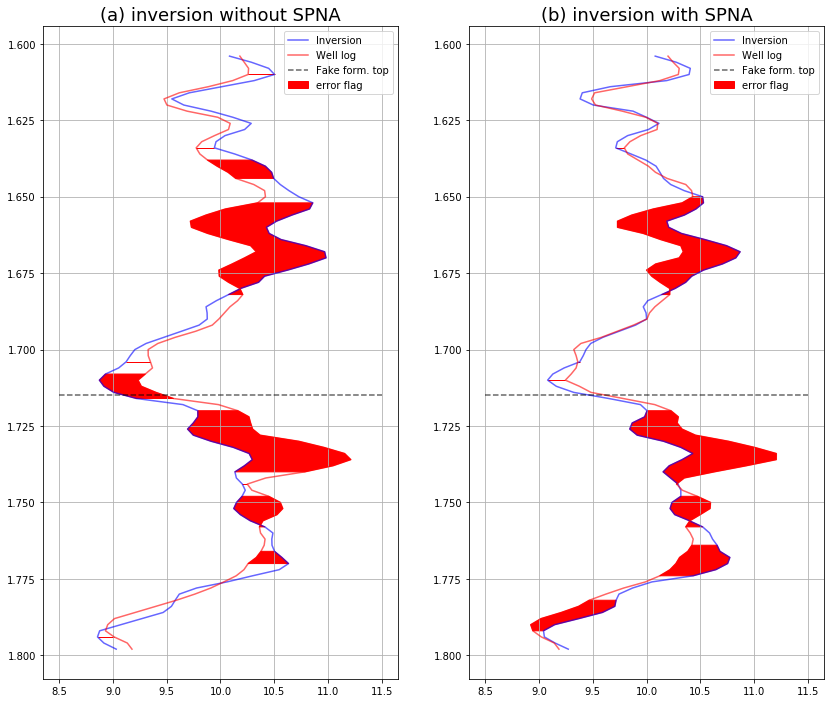

In [25]:
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(121)
ax1.plot(result_a.inv,result_a.time,'b', alpha = 0.6, label = 'Inversion')
ax1.plot(result_a.log,result_a.time,'r', alpha = 0.6, label = 'Well log')
ax1.plot([8.5, 11.5], [fake_top, fake_top], 'k--', alpha = 0.6, label = 'Fake form. top')
ax1.fill_betweenx(result_a.time, result_a.inv, result_a.log, where=result_a['flag']==1, 
                  color = 'r', label='error flag')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()
ax1.set_title('(a) inversion without SPNA', fontsize = 18)

ax2 = fig.add_subplot(122)
ax2.plot(result_b.inv,result_b.time,'b', alpha = 0.6, label = 'Inversion')
ax2.plot(result_b.log,result_b.time,'r', alpha = 0.6, label = 'Well log')
ax2.plot([8.5, 11.5], [fake_top, fake_top], 'k--', alpha = 0.6, label = 'Fake form. top')
ax2.fill_betweenx(result_b.time, result_b.inv, result_b.log, where=result_b['flag']==1, 
                  color = 'r', label='error flag')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()
ax2.set_title('(b) inversion with SPNA', fontsize = 18);

#### Count the number and percentage of samples that have been flagged for each result

In [26]:
zone_errors_a['flagged samples'] =  result_a.groupby('zone', sort=False).flag.sum().values

In [27]:
zone_errors_b['flagged samples'] =  result_b.groupby('zone', sort=False).flag.sum().values

In [28]:
def calc_proportion(dtf):
    """
    function to calculate proportion of flagged samples
    """
    x = dtf.flag
    return round(100 * x.sum()/len(x), 1)

In [29]:
zone_errors_a['proportion (%)'] =  result_a.groupby('zone', sort=False).apply(calc_proportion).values
zone_errors_b['proportion (%)'] =  result_b.groupby('zone', sort=False).apply(calc_proportion).values

In [30]:
display_side_by_side(zone_errors_a, zone_errors_b)

zone,RMSE,flagged samples,proportion (%)
Upper,0.375958,27.0,48.2
Lower,0.409672,23.0,54.8
zone,RMSE,flagged samples,proportion (%)
Upper,0.237558,20.0,35.7
Lower,0.368419,31.0,73.8


__The error flag method is in agreement with the RMS result: case b, the inversion on Singal Protected Noise Attenuated data is a better result for the `Upper` zone, but not for the `Lower` zone.__

### Diving deeper still

I was inspired to probe even deeper after reading the [chapter on Estimation](https://www.inferentialthinking.com/chapters/13/Estimation.html) from [Computational and Inferential Thinking](https://www.inferentialthinking.com/chapters/13/3/Confidence_Intervals.html) (UC Berkreley). Specifically, I was left with the question in mind: "Could these estimated error proportions have been different, with different samples, and how different?" And by that, I mean in a statistical sense, i.e. with different inversions at different blind well locations?

This question can be answered by creating a Confidence Interval for the proportions (of flagged samples) , wihch I do below using the [code in the book]((https://www.inferentialthinking.com/chapters/13/3/Confidence_Intervals.html#Confidence-Interval-for-a-Population-Proportion:-Bootstrap-Percentile-Method), with some modifications and some other tool from the [datascience library](http://data8.org/datascience/tutorial.html).

#### Create data tables

I first create [tables from the DataFrames](http://data8.org/datascience/_autosummary/datascience.tables.Table.from_df.html#datascience.tables.Table.from_df). Tables are [sequences of labeled columns of data](http://data8.org/datascience/tables.html#tables-overview).

In [31]:
from datascience import Table

In [32]:
result_a_bool = result_a.copy()
result_a_bool.flag=result_a_bool.flag.astype('bool') 

result_b_bool = result_b.copy()
result_b_bool.flag=result_b_bool.flag.astype('bool') 

In [33]:
table_a = Table.from_df(result_a_bool)
table_a

time,inv,log,zone,flag
1.604,10.084,10.18,Upper,False
1.606,10.287,10.2205,Upper,False
1.608,10.448,10.261,Upper,False
1.61,10.502,10.257,Upper,True
1.612,10.314,10.1137,Upper,False
1.614,10.012,9.887,Upper,False
1.616,9.71,9.617,Upper,False
1.618,9.5475,9.475,Upper,False
1.62,9.659,9.502,Upper,False
1.622,9.912,9.68967,Upper,False


In [34]:
table_b = Table.from_df(result_b_bool)
table_b

time,inv,log,zone,flag
1.604,10.08,10.199,Upper,False
1.606,10.276,10.247,Upper,False
1.608,10.406,10.303,Upper,False
1.61,10.395,10.295,Upper,False
1.612,10.1875,10.123,Upper,False
1.614,9.663,9.82,Upper,False
1.616,9.402,9.517,Upper,False
1.618,9.382,9.489,Upper,False
1.62,9.50467,9.525,Upper,False
1.622,9.874,9.774,Upper,False


#### Create the two bootstaps and confidence intervals for case a (without SPNA) and b (with SPNA)

In [35]:
from datascience import make_array, percentile

In [36]:
def bootstrap_proportion(original_sample, label, replications):
    
    """
    Returns an array of bootstrapped sample proportions:
    original_sample: table containing the original sample
    label: label of column cont`aining the Boolean variable
    replications: number of bootstrap samples
    
    Source: https://www.inferentialthinking.com/chapters/13/3/Confidence_Intervals.html
    """
    
    just_one_column = original_sample.select(label)
    proportions = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resample_array = bootstrap_sample.column(0)
        resampled_proportion = np.count_nonzero(resample_array)/len(resample_array)
        proportions = np.append(proportions, resampled_proportion)
        
    return np.around(proportions, 2) # modified to round to 2 decimals

In [37]:
def bootstrap_proportion_wrapper(original_sample, label, replications, low, up):
    """
    wrapper function that calls the bootstrap_proportion function and returns the C.I directly
    """
    bootstrap = bootstrap_proportion(original_sample, label, replications) 
    left = percentile(low, bootstrap)
    right= percentile(up, bootstrap)
    CI = make_array(left, right)
    return CI

In [38]:
zone_errors_a['90% C.I.'] =[(bootstrap_proportion_wrapper(table_a.where('zone', z), label='flag',
                                                          replications=5000, low=5, up=95)) for z in ['Upper', 'Lower']]

In [39]:
zone_errors_b['90% C.I.'] =[(bootstrap_proportion_wrapper(table_b.where('zone', z), label='flag',
                                                          replications=5000, low=5, up=95)) for z in ['Upper', 'Lower']]

In [40]:
display_side_by_side(zone_errors_a, zone_errors_b)

zone,RMSE,flagged samples,proportion (%),90% C.I.
Upper,0.375958,27.0,48.2,"[0.38, 0.59]"
Lower,0.409672,23.0,54.8,"[0.43, 0.67]"
zone,RMSE,flagged samples,proportion (%),90% C.I.
Upper,0.237558,20.0,35.7,"[0.27, 0.46]"
Lower,0.368419,31.0,73.8,"[0.62, 0.83]"


I am really excited this worked, but I do really beloeve that an image is better than a thousand words, so I put in a bit more work to show the distrubutions.

#### Histograms

In [41]:
bootstrap_upper=Table(['No SPNA', 'SPNA'])
bootstrap_upper['No SPNA']=bootstrap_proportion(table_a.where('zone', 'Upper'), 'flag', 5000)
bootstrap_upper['SPNA']=bootstrap_proportion(table_b.where('zone', 'Upper'), 'flag', 5000)

In [42]:
bootstrap_lower=Table(['No SPNA', 'SPNA'])
bootstrap_lower['No SPNA']=bootstrap_proportion(table_a.where('zone', 'Lower'), 'flag', 5000)
bootstrap_lower['SPNA']=bootstrap_proportion(table_b.where('zone', 'Lower'), 'flag', 5000)

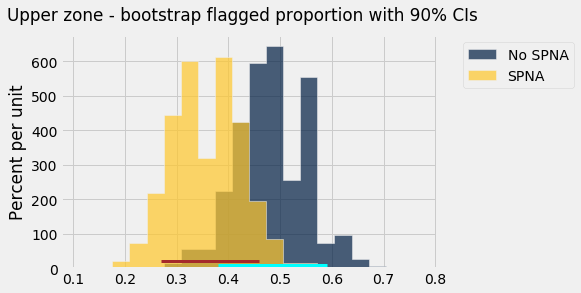

In [43]:
plt.style.use('fivethirtyeight')
bootstrap_upper.select(['No SPNA','SPNA']).hist(overlay=True,bins=20,normed=True)
plt.plot(make_array(zone_errors_a['90% C.I.'][0][0], zone_errors_a['90% C.I.'][0][1]), make_array(0.1, 0.1), 
         color='cyan', lw=3);
plt.plot(make_array(zone_errors_b['90% C.I.'][0][0], zone_errors_b['90% C.I.'][0][1]), make_array(0.2, 0.2), 
         color='brown', lw=3);

fig = plt.gcf()
fig.suptitle('Upper zone - bootstrap flagged proportion with 90% CIs');

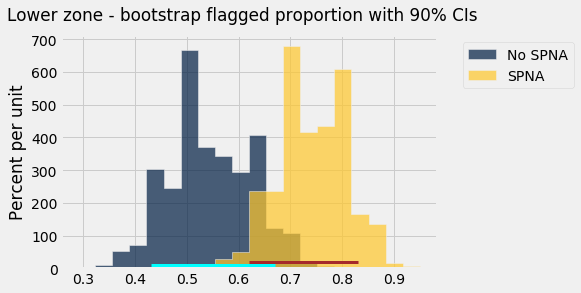

In [44]:
plt.style.use('fivethirtyeight')
bootstrap_lower.select(['No SPNA','SPNA']).hist(overlay=True,bins=20,normed=True)

plt.plot(make_array(zone_errors_a['90% C.I.'][1][0], zone_errors_a['90% C.I.'][1][1]), make_array(0.1, 0.1), 
         color='cyan', lw=3);
plt.plot(make_array(zone_errors_b['90% C.I.'][1][0], zone_errors_b['90% C.I.'][1][1]), make_array(0.2, 0.2), 
         color='brown', lw=3);

fig = plt.gcf()
fig.suptitle('Lower zone - bootstrap flagged proportion with 90% CIs');

__The two plots above show, for the `Upper` and `Lower` zone, respectively, the distribution of bootstrap flagged proportions for the two inversion results.__